In [1]:
import h5py
with h5py.File("__run__/CE_Bavera_2020.h5", "r") as hf:
    theta_true = hf["test_theta"][()]
    m1, m2 = theta_true[:,0], theta_true[:, 1]
    m2_c = m2.copy()
    m1_c = m1.copy()
    m1[m1<m2] = m2[m1<m2]
    m2[m1_c<m2_c] = m1_c[m1_c<m2_c]
    chi=theta_true[:,-2]
    mc = ((m1*m2)**(3.0/5.0))/((m1+m2)**(1.0/5.0))
    q = m2/m1

In [2]:
# !pip install seaborn

In [3]:
import matplotlib
from matplotlib.transforms import Bbox
import matplotlib.transforms as mtransforms
import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
colors=sns.color_palette('colorblind')
fs=28
import numpy as np

In [4]:
data_true = np.loadtxt('dense_test_set.txt')

In [5]:
m1ut, m2ut = data_true[:,0], data_true[:, 1]
xmin,xmax= 2.3, 22.0
m2_c = m2ut.copy()
m1_c = m1ut.copy()
m1ut[m1ut<m2ut] = m2ut[m1ut<m2ut]
m2ut[m1_c<m2_c] = m1_c[m1_c<m2_c]
chiut=data_true[:,-2]
mcut = ((m1ut*m2ut)**(3/5))/((m1ut+m2ut)**(1/5))
qut = m2ut/m1ut

In [7]:
import pickle
import numpy as np
with open("ppd_cal_pdfs_500_025_4p.pkl", "rb") as pf:
    data = np.array(pickle.load(pf))
    print(data.shape)
    data[:,:,:2] = np.exp(data[:,:,:2])
data.shape

(4400, 800000, 4)


(4400, 800000, 4)

In [8]:
qmax = 0.41
chimax = 0.7
mcmin = 7
mcmax = 100

argut = (qut<qmax)*(mcut>mcmin)*(mcut<mcmax)*(chiut<chimax)
print(len(mcut[argut]))
arg = (q<qmax)*(mc<mcmax)*(mc>mcmin)*(chi<chimax)#*(chi>ymin)*
print(len(mc[arg]))


2552
24
3534


In [9]:
mcamps, qamps, chiamps, argfs = [ ], [ ], [ ], [ ]
import tqdm
for i in tqdm.tqdm(range(4400)):
    m1amp, m2amp = data[i,:,0], data[i,:, 1]
    xmin,xmax= 2.3, 22.0
    m2_c = m2amp.copy()
    m1_c = m1amp.copy()
    m1amp[m1amp<m2amp] = m2amp[m1amp<m2amp]
    m2amp[m1_c<m2_c] = m1_c[m1_c<m2_c]
    chiamp=data[i,:,-2]
    mcamp = ((m1amp*m2amp)**(3/5))/((m1amp+m2amp)**(1/5))
    qamp = m2amp/m1amp
    argf = (qamp<qmax)*(mcamp<mcmax)*(mcamp>mcmin)*(chiamp<chimax)#*(chiamp>ymin)*(chiamp<ymax)*
    #print(len(mcamp[argf]))
    mcamps.append(mcamp)
    qamps.append(qamp)
    chiamps.append(chiamp)
    argfs.append(argf)


100%|██████████| 4400/4400 [03:07<00:00, 23.41it/s]


In [21]:
samps = np.loadtxt('/home/anarya.ray/jaxflows/paper/naz/examples/papers/1/amplified_samples_inclusive_16.txt')
m1,m2,chiamp = np.exp(samps[:,0]), np.exp(samps[:,1]), samps[:,2]
mcamp = ((m1*m2)**(3/5))/((m1+m2)**(1/5))
qamp = m2/m1
qamp[qamp>1] = 1/qamp[qamp>1]
argamp = (qamp<qmax)*(mcamp<mcmax)*(mcamp>mcmin)*(chiamp<chimax)#*(chiamp>ymin)*(chiamp<ymax)*
print(len(mcamp[argamp]))

3534


In [10]:
from pesummary.core.plots.bounded_1d_kde import bounded_1d_kde

In [11]:
nbins = 15
mcbin = np.linspace(mcmin,15,nbins)
chibin = np.linspace(chiut.min(), 0.8, nbins)

x = 0.5*(chibin[1:]+chibin[:-1])
bounds = (x.min(), x.max())
print(bounds)
X = np.linspace(x.min(),x.max(),100)

(-0.07199862210581326, 0.7677037547368217)


In [12]:
ranges = (min(data_true[:,2]),chimax)# max(data_true[:,2]))
nbins = 11

In [13]:
from scipy.stats import gaussian_kde
pdfs = []
chi_range = np.linspace(ranges[0], ranges[1], 100)
for i in tqdm.tqdm(range(4400)):
    try:
        
        kde = gaussian_kde(chiamps[i][argfs[i]])
    except Exception as e:
        print(e)
        print(chiamps[i][argfs[i]].shape)
        continue
    y = kde.pdf(chi_range)
    y/=np.trapz(y,chi_range)
    pdfs.append(y)


100%|██████████| 4400/4400 [00:25<00:00, 174.09it/s]


In [14]:
pdfs = np.array(pdfs)

In [15]:
# # print(pdfs_05, pdfs_95)
# y = np.array(pdfs)

# chi_ls = np.array([])
# nc = 100
# for i, c in enumerate(cbins[:-1]):
#     chi_ls = np.append(chi_ls, np.linspace(c,cbins[i+1], nc))
#     if i == 0:
#         y_new = y[:,i][:,None] * np.ones(nc)[None,:]
#     else:
#         y_new = np.concatenate((y_new, y[:,i][:,None] * np.ones(nc)[None,:]), axis=-1)



In [16]:
def hpd_vectorized(samples, alpha=0.1):
    """
    Vectorized HPD for samples with shape (ns, nx, ny), returns (2, nx, ny)
    """
    # Sort along the sample axis (axis=0)
    x = np.sort(samples, axis=0)
    ns = x.shape[0]
    cred_mass = 1.0 - alpha
    interval_idx_inc = int(np.floor(cred_mass * ns))
    n_intervals = ns - interval_idx_inc

    if n_intervals <= 0:
        raise ValueError("Too few elements for interval calculation")

    # Compute interval widths: shape (n_intervals, nx, ny)
    interval_width = x[interval_idx_inc:, ...] - x[:n_intervals, ...]

    # Find the index with the smallest width along axis 0
    min_idx = np.argmin(interval_width, axis=0)  # shape (nx, ny)

    # Prepare an output array of shape (2, nx, ny)
    hdi_min = np.take_along_axis(x, min_idx[None, :, :], axis=0)[0]
    hdi_max = np.take_along_axis(x, (min_idx + interval_idx_inc)[None, :, :], axis=0)[0]

    return np.stack([hdi_min, hdi_max], axis=0)

In [17]:
def hpd(samples,alpha = 0.1):
    x=np.sort(np.copy(samples))
    n = len(x)
    cred_mass = 1.0-alpha

    interval_idx_inc = int(np.floor(cred_mass*n))
    n_intervals = n - interval_idx_inc
    interval_width = x[interval_idx_inc:] - x[:n_intervals]

    if len(interval_width) == 0:
        raise ValueError('Too few elements for interval calculation')

    min_idx = np.argmin(interval_width)
    hdi_min = x[min_idx]
    hdi_max = x[min_idx+interval_idx_inc]

    return [hdi_min, hdi_max]

In [19]:
print(chi_range[0])

-0.10429486736899153


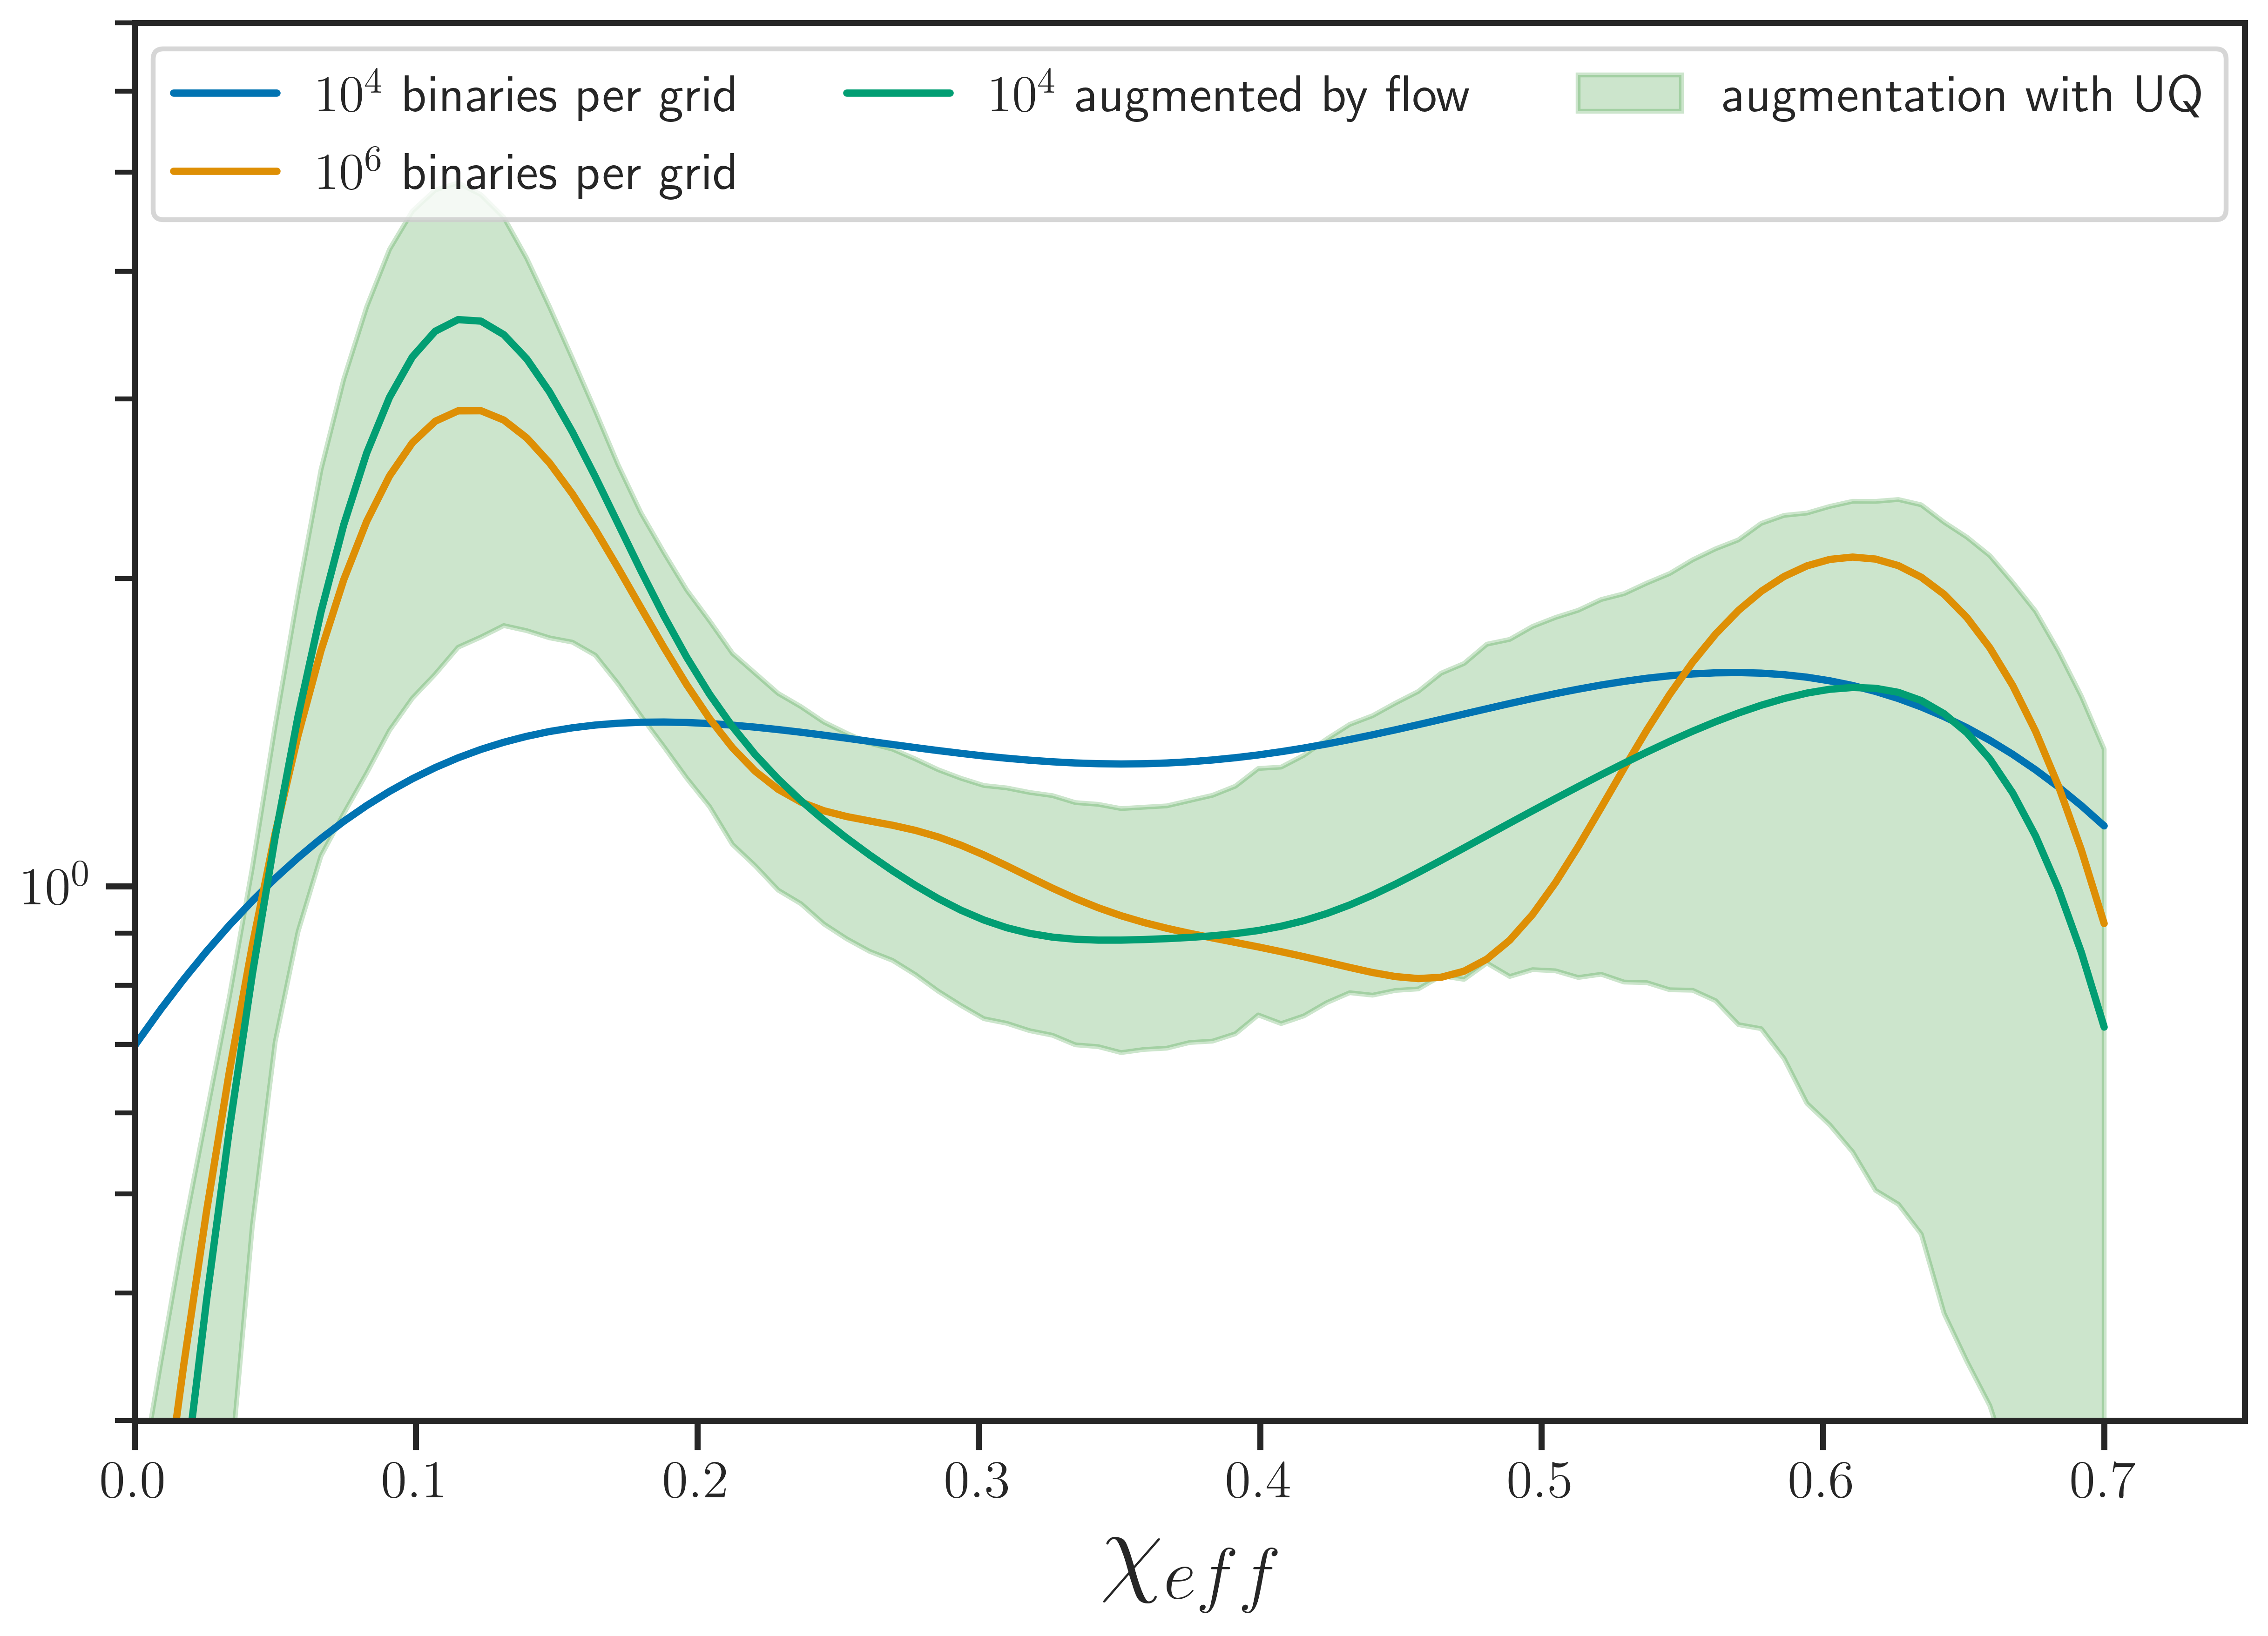

In [22]:
fig,ax = plt.subplots(1, figsize=(9*1.3,6*1.3), dpi =500)

from scipy.stats import gaussian_kde
ar = (X<bounds[0]) + (X>bounds[1])

kde = gaussian_kde(chi[arg])
y = kde.pdf(chi_range)
y/=np.trapz(y,chi_range)
ax.plot(chi_range, y, label = r"$10^4$ binaries per grid")
#ax.hist(chi[arg], density = True, bins = nbins, range = ranges, label = r"$10^4$ binaries per grid", histtype = 'step')



kde = gaussian_kde(chiut[argut])
y = kde.pdf(chi_range)
y/=np.trapz(y,chi_range)
ax.plot(chi_range, y, label = r"$10^6$ binaries per grid")
#ax.hist(chiut[argut], density = True, bins = nbins, range = ranges,label = r"$10^6$ binaries per grid", histtype = 'step')

kde = gaussian_kde(chiamp[argamp])
y = kde.pdf(chi_range)
#y+=kde.pdf(bounds[0]-X)
y/=np.trapz(y,chi_range)
_=ax.plot(chi_range, y, label = r"$10^4$ augmented by flow")

quantiles = np.array([hpd(this_pdf) for this_pdf in pdfs.T])#y_new.T])

pdfs_05 = quantiles[:,0]
pdfs_95 = quantiles[:,1]

ax.fill_between(chi_range, pdfs_05, pdfs_95,
                         alpha = 0.2, color = 'green',
                         label = "augmentation with UQ")#, step = "post")


ax.legend(fontsize = 16, loc = "upper center", ncol=3)
ax.set_xlabel(r"$\chi_{eff}$", fontsize = 32)
ax.set_yscale('log')
ax.set_ylim(0.3,7)
#plt.grid()
plt.xlim(0,0.75)
plt.savefig("Bayesian_amplification_kde.png")
plt.show()